## Create SBML models using BioCRNpyler

In [ ]:
from biocrnpyler import (
    Enzyme,
    Mixture,
    BasicCatalysis,
    MichaelisMenten,
)

default_parameters = {"kb": 100, "ku": 10, "kcat": 1.0}
E = Enzyme("E", substrates="S", products="P")
mech_cat = BasicCatalysis()
default_mechanisms = {mech_cat.mechanism_type: mech_cat}
M = Mixture(
    "Catalysis Mixture",
    components=[E],
    parameters=default_parameters,
    mechanisms=default_mechanisms,
)
CRN = M.compile_crn()
CRN.write_sbml_file("models/example_1.xml")

In [1]:
#Also notice that the names of transcript and protein can be changed, or set to Species.
total_RNAP = 10
total_Ribo = 50
total_DNA = 0.5
x0_dict = {"protein_RNAP_machinery":total_RNAP,
           "protein_Ribo_machinery":total_Ribo,
           "dna_X":total_DNA}

try:
    from biocrnpyler import * # type: ignore
    class GeneExpressionExtract(Mixture):
        def __init__(self, name="", rnap="RNAP", ribosome="Ribo", **kwargs):
            """Initializes a TxTlExtract instance.

            :param name: name of the mixture
            :param rnap: name of the RNA polymerase, default: RNAP
            :param ribosome: name of the ribosome, default: Ribo
            :param kwargs: keywords passed into the parent Class (Mixture)
            """
            # Always call the superlcass Mixture.__init__(...)
            Mixture.__init__(self, name=name, **kwargs)

            # create default Components to represent cellular machinery
            self.rnap = Protein(rnap, attributes=["machinery"])
            self.ribosome = Protein(ribosome, attributes=["machinery"])

            default_components = [self.rnap, self.ribosome]
            self.add_components(default_components)

            # Create default TxTl Mechanisms
            mech_tx = Transcription_MM(rnap=self.rnap.get_species())
            mech_tl = Translation_MM(ribosome=self.ribosome.get_species())
            mech_cat = MichaelisMenten()
            mech_bind = One_Step_Binding()

            default_mechanisms = {
                mech_tx.mechanism_type: mech_tx,
                mech_tl.mechanism_type: mech_tl,
                mech_cat.mechanism_type: mech_cat,
                mech_bind.mechanism_type: mech_bind
            }
            self.add_mechanisms(default_mechanisms)
            # global mechanisms for dilution and rna degredation
            mech_rna_deg_global = Dilution(name="rna_degradation",
                                        filter_dict={"rna": True,
                                                     "complex":False},
                                        default_on=False)
            mech_protein_deg_global = Dilution(name="protein_degradation",
                                            filter_dict={"protein": True,
                                                         "machinery":False,
                                                         "complex":False},
                                            default_on=False)
            global_mechanisms = {"rna_degradation": mech_rna_deg_global,
                                "protein_degradation":mech_protein_deg_global}
            self.add_mechanisms(global_mechanisms)
    G = DNAassembly("X", promoter = "strong", rbs = "weak",
                    transcript = None, protein = None)

    model_txtl = GeneExpressionExtract(
        "txtl", components = [G],
        parameter_file = "default_parameters.txt",
        initial_condition_dictionary = x0_dict
    )

    CRN = model_txtl.compile_crn()
    print(repr(CRN),"\n", CRN.pretty_print(show_attributes = False,
                                           show_material = True,
                                           show_rates = True),"\n\n")
    CRN.write_sbml_file("models/biocrnpyler_gene_expression.xml")
except Exception as e:
    print(e)
    # print('BioCRNpyler not found. To run this notebook, make sure you run pip install biocrnpyler first.')

Species = dna_X, protein_RNAP_machinery, rna_X, complex_dna_X_protein_RNAP_machinery_, protein_Ribo_machinery, protein_X, complex_protein_Ribo_machinery_rna_X_
Reactions = [
	dna[X]+protein[RNAP(machinery)] <--> complex[dna[X]:protein[RNAP]]
	complex[dna[X]:protein[RNAP]] --> dna[X]+rna[X]+protein[RNAP(machinery)]
	rna[X]+protein[Ribo(machinery)] <--> complex[protein[Ribo]:rna[X]]
	complex[protein[Ribo]:rna[X]] --> rna[X]+protein[X]+protein[Ribo(machinery)]
	rna[X] --> 
	protein[X] --> 
] 
 Species(N = 7) = {
complex[protein[Ribo]:rna[X]] (@ 0),  complex[dna[X]:protein[RNAP]] (@ 0),  protein[X] (@ 0),  rna[X] (@ 0),  dna[X] (@ 0),  protein[Ribo] (@ 0),  protein[RNAP] (@ 0),  
}

Reactions (6) = [
0. dna[X]+protein[RNAP] <--> complex[dna[X]:protein[RNAP]]
 Kf=k_forward * dna_X * protein_RNAP_machinery
 Kr=k_reverse * complex_dna_X_protein_RNAP_machinery_
  k_forward=100.0
  found_key=(mech=None, partid=None, name=kb).
  search_key=(mech=transcription_mm, partid=strong, name=kb).
  k_rev

c:\Users\ayush\anaconda3\envs\py311-new\Lib\site-packages\biocrnpyler\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "
c:\Users\ayush\anaconda3\envs\py311-new\Lib\site-packages\biocrnpyler\global_mechanism.py:104: UserWarning: species complex_protein_Ribo_machinery_rna_X_ has multiple attributes(or material type) which conflict with global mechanism filter rna_degradation. Using default value False.
  warn(f"species {repr(s)} has multiple attributes(or material type) which conflict with global mechanism filter {repr(self)}. Using default value {self.default_on}.")
c:\Users\ayush\anaconda3\envs\py311-new\Lib\site-packages\biocrnpyler\global_mechanism.py:104: UserWarning: species protein_RNAP_machinery has multiple attributes(or material type) which conflict with global mechanism filter protein_degradation. Using default value False.
  warn(f"speci

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from autoreduce import *
import numpy as np
from sympy import symbols

In [3]:
from autoreduce.converters import load_sbml
from sympy import Symbol
sys = load_sbml('models/biocrnpyler_gene_expression.xml',
                outputs = ['protein_X'])
for x, x_ic in x0_dict.items():
    curr_ind = sys.x.index(Symbol(x))
    sys.x_init[curr_ind] = x_ic

In [4]:
sys.x

[dna_X,
 protein_RNAP_machinery,
 rna_X,
 complex_dna_X_protein_RNAP_machinery_,
 protein_Ribo_machinery,
 protein_X,
 complex_protein_Ribo_machinery_rna_X_]

In [5]:
new_params_values = [100.0, 0.5, 3.926187672,
                     5.0, 0.05, 0.01]
sys.params_values = new_params_values

# Create and solve the ODE for the model

Text(0.5, 0, 'Time')

Text(0, 0.5, '[Outputs]')

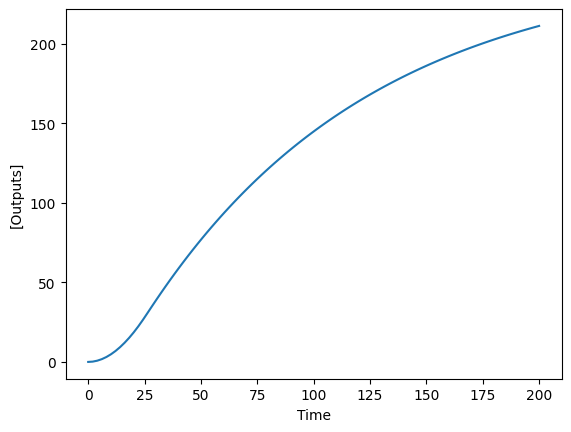

In [6]:
from autoreduce.utils import get_ODE
import numpy as np
timepoints_ode = np.linspace(0, 200, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    full_model = np.transpose(np.array(sys.C)@sol)
    plt.plot(timepoints_ode, full_model)
    plt.xlabel('Time')
    plt.ylabel('[Outputs]')
    plt.show()
except:
    print('Plotting libraries missing.')

# Local sensitivity analysis for BioCRNpyler model

In [7]:
from autoreduce.utils import get_SSM
timepoints_ssm = np.linspace(0,20,10)
sys_ssm = get_SSM(sys, timepoints_ssm)
# Uncomment to run
# Ss = sys_ssm.compute_SSM() # len(timepoints) x len(params) x len(states)

In [8]:
# out_Ss = []
# for i in range(len(sys.params)):
#     out_Ss.append((np.array(sys.C)@(Ss[:,i,:].T)))
# out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(sys.params), 1))

# Plot heatmap for sensitivity analysis

In [9]:
# try:
#     import seaborn as sn
#     import matplotlib.pyplot as plt
#     sn.heatmap(out_Ss[:,:,0].T)
#     plt.xlabel('Time')
#     plt.ylabel('Parameters')
#     plt.title('Sensitivity of protein with all parameters'.format(j))
#     plt.show()
# except:
#     print('Plotting libraries missing.')

# Model reduction starts here:

In [10]:
sys = load_sbml('models/biocrnpyler_gene_expression.xml',
                outputs = ['protein_X'])
for x, x_ic in x0_dict.items():
    curr_ind = sys.x.index(Symbol(x))
    sys.x_init[curr_ind] = x_ic

In [11]:
sys.x

[dna_X,
 protein_RNAP_machinery,
 rna_X,
 complex_dna_X_protein_RNAP_machinery_,
 protein_Ribo_machinery,
 protein_X,
 complex_protein_Ribo_machinery_rna_X_]

# Conservation Laws (if any)

In [12]:
G, P, T, C1, R, X, C2 = sys.x
conserved_sets = [[P,C1],[R,C2]]
con = sys.solve_conservation_laws(conserved_sets=conserved_sets,
                                  states_to_eliminate=[P, R])

Found conservation laws: [complex_dna_X_protein_RNAP_machinery_ + protein_RNAP_machinery - protein_RNAP_machinery_total, complex_protein_Ribo_machinery_rna_X_ + protein_Ribo_machinery - protein_Ribo_machinery_total]


In [13]:
sys.params_values = new_params_values + [total_RNAP, total_Ribo]

In [14]:
sys.x

[dna_X,
 rna_X,
 complex_dna_X_protein_RNAP_machinery_,
 protein_X,
 complex_protein_Ribo_machinery_rna_X_]

Text(0.5, 0, 'Time')

Text(0, 0.5, '[Outputs]')

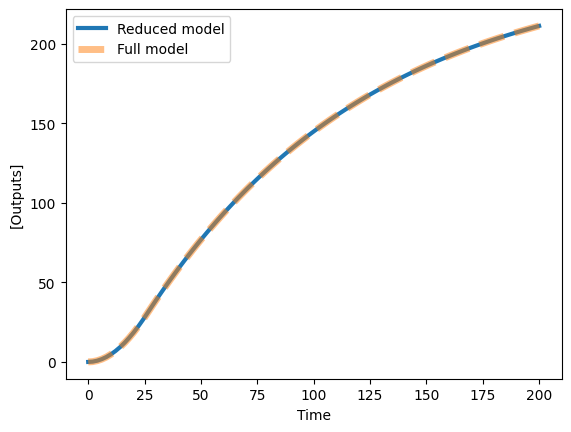

In [15]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 200, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    plt.plot(timepoints_ode, np.transpose(np.array(sys.C)@sol),
             lw = 3, label = 'Reduced model')
    plt.plot(timepoints_ode, full_model, '--',
             alpha = 0.5, lw = 5, label = 'Full model')
    plt.xlabel('Time')
    plt.ylabel('[Outputs]')
    plt.legend()
    plt.show()
except:
    print('Plotting libraries missing.')

In [16]:
sys.x

[dna_X,
 rna_X,
 complex_dna_X_protein_RNAP_machinery_,
 protein_X,
 complex_protein_Ribo_machinery_rna_X_]

# Derive model with no intermediate complexes

In [17]:
reduced_sys, fast_ss = sys.solve_timescale_separation([G,T,X])

Successful solution obtained with states: [dna_X, rna_X, protein_X]!


In [18]:
reduced_sys.x

[dna_X, rna_X, protein_X]

Text(0.5, 0, 'Time')

Text(0, 0.5, '[Outputs]')

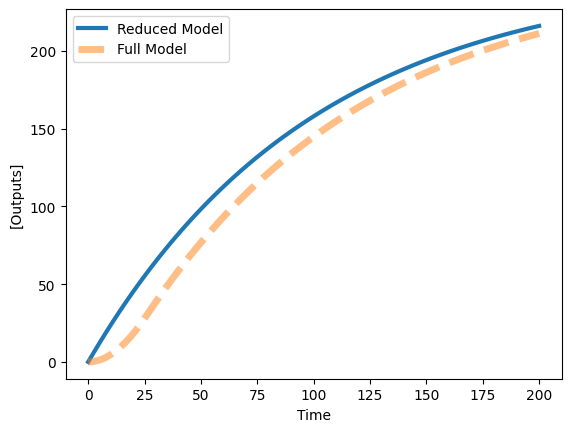

In [19]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 200, 100)
# reduced_sys.params_values = new_params_values + []
reduced_ode = get_ODE(reduced_sys, timepoints_ode)
sol = reduced_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    plt.plot(timepoints_ode, sol[2,:], lw = 3, label='Reduced Model')
    plt.plot(timepoints_ode, full_model, '--', lw = 5, alpha = 0.5, label='Full Model')
    plt.xlabel('Time')
    plt.ylabel('[Outputs]')
    plt.legend()
    plt.show()
except:
    print('Plotting libraries missing.')

## Write the reduced model to an SBML file to integrate other tools!

In [20]:
reduced_sys.write_sbml("models/reduced_gene_expression.xml")

<SBMLDocument>